In [ ]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../'))
%matplotlib inline

In [2]:
import bespoke_solvers 
import minmax_regret_game
import minmax_regret_ilp
import regret_minimization_dp



In [3]:

asset_covars = np.genfromtxt("../data/cov_nolabels.csv", delimiter=",")
asset_returns = np.genfromtxt("../data/returns_nolabels.csv", delimiter=",")



In [4]:

asset_weights, portfolio_return = bespoke_solvers.max_return_constrain_variance(
    asset_returns, asset_covars, 0.0001, 1, long_only=True)


In [14]:
asset_weights, portfolio_risk = bespoke_solvers.min_risk_constrain_returns(
    asset_returns, asset_covars, 0.00085522, 1, long_only=True)


In [6]:
def bespoke_return(risk):
    w, r = bespoke_solvers.max_return_constrain_variance(
        asset_returns, asset_covars, risk, 1.0, long_only=True)
    return r

In [5]:
def calc_empirical_distribution(products,n_prod_choices):
    #counts = np.asarray(np.unique([prod for round in products for prod in round],return_counts=True)).T 
    counts = [sum([i in products[t] for t in range(len(products))]) for i in range(n_prod_choices)]
    counts = [count/sum(counts) for count in counts]
    prods = [i for i in range(n_prod_choices)]
    return(pd.DataFrame(counts,prods).rename({0:'product'},axis=1))
    

Let's try out an example to see whether the support ends up being sparse or not. We'll generate data from several groups, each with their own mean but a common variance (normally distributed). Rather than trying to cook up an example, we'll just specify a normal prior with a given mean

In [7]:
prior_mean = 0.0001
prior_std = 0.00001
ngroups = 5
n_consumers=100
group_std = 0.000001

In [8]:
means =  np.random.normal(loc= prior_mean, scale =prior_std, size = ngroups)

In [9]:
consumer_groups = np.random.randint(low=0, high = ngroups, size = n_consumers)
consumer_risks = np.array([np.random.normal(loc=means[consumer_groups[i]],scale=group_std) for i in range(n_consumers)])
consumer_returns = np.array([bespoke_return(r) for r in consumer_risks])

In [10]:
means

array([8.43085953e-05, 9.39774870e-05, 1.07165014e-04, 1.17100295e-04,
       1.14442508e-04])

In [11]:
data = pd.DataFrame({'group':consumer_groups,'risk': consumer_risks,'returns':consumer_returns})

In [12]:
consumer_risks = np.array(data.sort_values('returns').risk)
consumer_groups = np.array(data.sort_values('returns').group)

Let's take a look at the observed risk and return densities. The risk should of course look almost normal.

group
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: risk, dtype: object

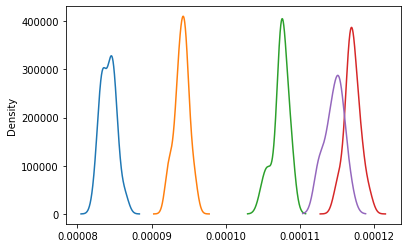

In [13]:
data.groupby('group').risk.plot(kind='kde')

group
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: returns, dtype: object

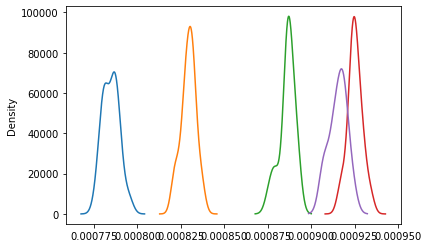

In [14]:
data.groupby('group').returns.plot.kde()

Now we run the game. We will do 1K time steps. We will bump up the step size by a factor of 10 to account for the fact that the way it is calculated uses the max regret possible, which is very low probability.

In [43]:
T=1000
max_group_regret = np.max(np.array([np.sum(consumer_returns[consumer_groups == i])
                                  for i in range(ngroups)]))
stepsize = np.sqrt(8 * np.log(ngroups) / T) / max_group_regret

products, group_weights, group_regrets = minmax_regret_game.minmax_regret_game(
    returns = consumer_returns, groups = consumer_groups, num_groups= ngroups, num_prods = 5 , T= T,use_avg_regret=False,stepsize = 10*stepsize )



In [44]:
products[-10:]

array([[ 0, 20, 26, 50, 72],
       [ 0, 20, 47, 64, 81],
       [ 0, 20, 47, 50, 68],
       [ 0, 20, 26, 50, 72],
       [ 0, 20, 47, 64, 81],
       [ 0, 20, 26, 50, 68],
       [ 0, 20, 47, 64, 81],
       [ 0, 20, 26, 50, 68],
       [ 0, 20, 47, 50, 72],
       [ 0, 20, 26, 50, 68]])

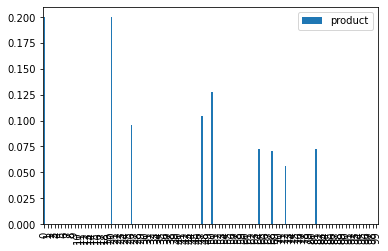

In [41]:
calc_empirical_distribution(products,len(np.unique(consumer_risks))).plot(kind='bar')

So, it looks like nearly all the products have probability zero on them. (this is the marginal distribution in equilibrium). Let's see how the fraction of non-zero support varies with k.

In [94]:
def run_for_n_prods(n_prods,threshold = 0):
    T=100
    n_prod_choices = len(consumer_returns)
    max_group_regret = np.max(np.array([np.sum(consumer_returns[consumer_groups == i])
                                      for i in range(ngroups)]))
    stepsize = np.sqrt(8 * np.log(ngroups) / T) / max_group_regret

    products, group_weights, group_regrets = minmax_regret_game.minmax_regret_game(
        returns = consumer_returns, groups = consumer_groups, num_groups= ngroups, num_prods = n_prods , T= T,use_avg_regret=False,stepsize = 10*stepsize )
    
    counts = [sum([i in products[t] for t in range(len(products))]) for i in range(n_prod_choices)]
    counts = [count/sum(counts) for count in counts]
    return([sum([counts[i]>threshold for i in range(len(counts))]),products,counts])

In [95]:
results =  [run_for_n_prods(i+1, 0) for i in range(50)]
pos_support = [result[0] for result in results]

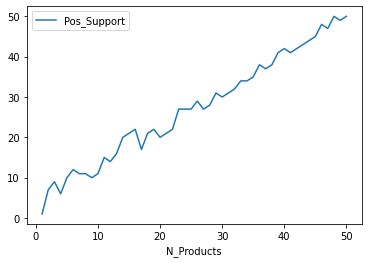

In [83]:
pd.DataFrame({'N_Products':[i+1 for i in range(len(pos_support))], 'Pos_Support':pos_support}).plot(x='N_Products',y='Pos_Support')

In [84]:
pos_support

[1,
 7,
 9,
 6,
 10,
 12,
 11,
 11,
 10,
 11,
 15,
 14,
 16,
 20,
 21,
 22,
 17,
 21,
 22,
 20,
 21,
 22,
 27,
 27,
 27,
 29,
 27,
 28,
 31,
 30,
 31,
 32,
 34,
 34,
 35,
 38,
 37,
 38,
 41,
 42,
 41,
 42,
 43,
 44,
 45,
 48,
 47,
 50,
 49,
 50]

In [91]:
pos_support_thresholds = [[run_for_n_prods(i+1, tau) for i in range(50)] for tau in np.linspace(0,0.5,11)] 

KeyboardInterrupt: 

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [87]:
np.linspace

<function numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)>